#  <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Homework 7: Classification with Logistic Regression, LDA/QDA, and Trees


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the [instructions given in Canvas](https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions).

- If needed, clarifications will be posted on Piazza.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below. 


**Name of the person you have worked with goes here:**
<br><BR>

<hr style="height:2pt">

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs
import warnings

warnings.filterwarnings('ignore')

<div class='exercise'><b> Question 1 [20 pts]: Overview of Multiclass Thyroid Classification </b></div>

In this problem set you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw7.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was [obtained from the UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Thyroid+Disease); for this assignment we chose two predictors so we can visualize the decision boundaries.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore different methods for multiclass classification.

For most of this problem set, we'll measure overall classification accuracy as the fraction of observations classified correctly.



**1.1** Load the data and examine its structure. How many instances of each class are there in our dataset? In particular, what is the ratio of the number of observations in class 2 (hyperthyroidism) to the number of observations in class 3 (hypothyroidism)? We'll refer to this as the *hyper-to-hypo ratio*.

**1.2**: We're going to split this data into a 50% training set and a 50% test set. But since our dataset is small, we need to make sure we do it correctly. Let's see what happens when we *don't* split correctly: for each of 100 different random splits of the data into 50% train and 50% test, compute the hyper-to-hypo for the observations end up in the training set. Plot the distribution of the hyper-to-hypo ratio; on your plot, also mark the hyper-to-hypo ratio that you found in the full dataset. Discuss how representative the training and test sets are likely to be if we were to have selected one of these random splits.

**1.3** Now, we'll use the `stratify` option to split the data in such a way that the relative class frequencies are preserved (the code is provided). Make a table showing how many observations of each class ended up in your training and test sets. Verify that the hyper-hypo ratio is roughly the same in both sets.

**1.4** Provide the scatterplot of the predictors in the (training) data in a way that clearly indicates which class each observation belongs to.

**1.5**: When we first start working with a dataset or algorithm, it's typically a good idea to figure out what *baselines* we might compare our results to. For regression, we always compared against a baseline of predicting the mean (in computing $R^2$). For classification, a simple baseline is always predicting the *most common class*. What "baseline" accuracy can we achieve on the thyroid classification problem by always predicting the most common class? Assign the result to `baseline_accuracy` so we can use it later. (**note: don't look at the test set until instructed**)

**1.6** Make a decision function to separate these samples using no library functions; just write out your logic by hand. Your manual classifier doesn't need to be well-tuned (we'll be exploring algorithms to do that!); it only needs to (1) predict each class at least once, and (2) achieve an accuracy at least 10% greater accurate than predicting the most likely class. Use the `overlay_decision_boundaries` function provided above to overlay the decision boundaries of your function on the training set. (Note that the function modifies an existing plot, so call it after plotting your points.)

Based on your exploration, do you think a linear classifier (i.e., a classifier where all decision boundaries are line segments) could achieve above 85% accuracy on this dataset? Could a non-linear classifier do better? What characteristics of the data lead you to these conclusions?

**1.1**

In [3]:
# your code here
disorder_df=pd.read_csv('dataset_hw7.csv')
disorder_df.describe()


,Biomarker 1,Biomarker 2,Diagnosis
count,215.000000,215.000000,215.000000
mean,0.414441,0.303155,1.441860
std,0.888106,2.174369,0.726737
min,-2.302485,-11.512925,1.000000
25%,0.000010,-0.510809,1.000000
50%,0.262372,0.693152,1.000000
75%,0.530634,1.410989,2.000000
max,4.032469,4.030695,3.000000


In [4]:
# your code here
def hyper_rate(data):
    counts = data.Diagnosis.value_counts()
    rates = counts[2]/counts[3]
    return rates
print('The hyper-to-hypo ratio of this dataset is '+ str(hyper_rate(disorder_df)))

The hyper-to-hypo ratio of this dataset is 1.1666666666666667


**1.2**

Text(0.5,1,'Distribution of the Hyper-to-hypo Ratio of the Train Dataset')

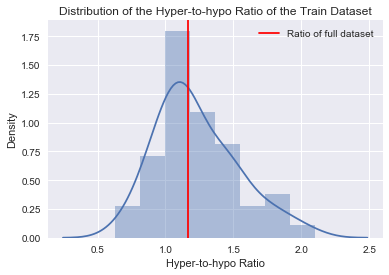

In [5]:
# your code here
rate=np.zeros(100)
np.random.seed(42)
for i in range(0,100):
    train, test = train_test_split(disorder_df, test_size=0.5)
    rate[i]=hyper_rate(train)
sns.distplot(rate)
plt.axvline(hyper_rate(disorder_df),color='red',label='Ratio of full dataset')
plt.legend()
plt.xlabel('Hyper-to-hypo Ratio')
plt.ylabel('Density')
plt.title('Distribution of the Hyper-to-hypo Ratio of the Train Dataset')

**your answer here**
From the Hyper-to-hypo ratio distribution over different train dataset, we can see that the distribution is almost normally distributed and the most train datasets a hyper-to-hypo ratio around the full dataset ratio. If we use randomly choose a random split, the training set may can't be representative since there are still many splits with hyper-to-hypo ratio much smaller or larger than the ratio of full dataset, thus, we can't use this method to split the dataset. 

**1.3**

In [6]:
data_train, data_test = train_test_split(disorder_df, test_size=.5, stratify=disorder_df.Diagnosis, random_state=99);

In [7]:
# your code here
train_count=data_train.Diagnosis.value_counts()
test_count=data_test.Diagnosis.value_counts()
count={'Normal':(train_count[1],test_count[1]),'Hyperthyroidism':(train_count[2],test_count[2]),
       'Hypothyroidism':(train_count[3],test_count[3])}
k=pd.DataFrame.from_dict(count,orient='index',columns=['Train_set', 'Test_set'])
k

,Train_set,Test_set
Normal,75,75
Hyperthyroidism,17,18
Hypothyroidism,15,15


In [8]:
# your code here
print('The hyper-to-hypo ratio of train dataset is '+ str(hyper_rate(data_train))
    + 'The hyper-to-hypo ratio of test dataset is '+ str(hyper_rate(data_test)))

The hyper-to-hypo ratio of train dataset is 1.1333333333333333The hyper-to-hypo ratio of test dataset is 1.2


**1.4**

Text(0.5,1,'Distribution of the Biomarkers of three different people classes')

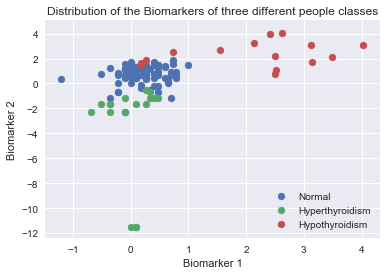

In [9]:
# your code here
plt.scatter(data_train.loc[data_train['Diagnosis']==1,['Biomarker 1']]
               ,data_train.loc[data_train['Diagnosis']==1,['Biomarker 2']],label='Normal')
plt.scatter(data_train.loc[data_train['Diagnosis']==2,['Biomarker 1']]
               ,data_train.loc[data_train['Diagnosis']==2,['Biomarker 2']],label='Hyperthyroidism')
plt.scatter(data_train.loc[data_train['Diagnosis']==3,['Biomarker 1']]
               ,data_train.loc[data_train['Diagnosis']==3,['Biomarker 2']],label='Hypothyroidism')
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.legend()
plt.title('Distribution of the Biomarkers of three different people classes')

**1.5**

In [10]:
# your code here
baseline_accuracy=accuracy_score(np.ones(len(data_train['Diagnosis']))
                                 ,data_train['Diagnosis'])
print('Baseline accuracy of the train dataset is '+ str(baseline_accuracy))

Baseline accuracy of the train dataset is 0.7009345794392523


**1.6**

In [11]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier (has a `.predict` method)
    X: feature vectors
    y: ground-truth classes
    colors: list of colors to use. Use color colors[i] for class i.
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    """
    # Create mesh
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points
    if hasattr(model, 'predict'):
        model = model.predict
    y = model(X)
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        colors = sns.utils.get_color_cycle()
        y -= y.min() # If first class is not 0, shift.
    assert np.max(y) <= len(colors)
    colors = [sns.utils.desaturate(color, desaturate) for color in colors]
    cmap = matplotlib.colors.ListedColormap(colors)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
#     ax.contourf(xx, yy, y, cmap=cmap, vmin=0, vmax=3)
    ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)

In [12]:
# your code here
X=data_train.loc[:,['Biomarker 1','Biomarker 2']].values
Y=data_train.loc[:,['Diagnosis']].values

In [13]:
# Update the following function:
def predict_manual_one_sample(x):
    if x[0]>1:
        y=3
    elif x[1]<-1:
        y=2
    else:
        y=1
    return y

In [14]:
# your code here:
predict_manual_one_sample(X[0])

2

In [15]:
def predict_manual(X):
    return np.array([predict_manual_one_sample(x) for x in X])

manual_predictions = predict_manual(X)
accuracy = accuracy_score(Y, manual_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9158878504672897


In [16]:
assert accuracy >= (baseline_accuracy * 1.10), "Accuracy too low"
assert all(np.sum(manual_predictions == i) > 0 for i in [1, 2, 3]), "Should predict each class at least once."

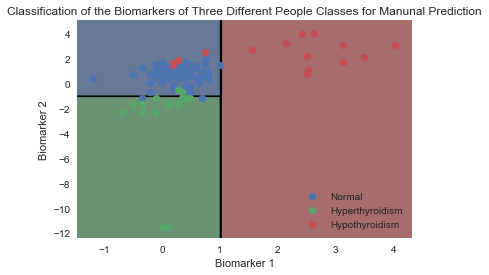

In [17]:
# Your code here
def plt_classify(ax,data,model,name):
    ax.scatter(data.loc[data['Diagnosis']==1,['Biomarker 1']]
               ,data.loc[data['Diagnosis']==1,['Biomarker 2']],label='Normal')
    ax.scatter(data.loc[data['Diagnosis']==2,['Biomarker 1']]
               ,data.loc[data['Diagnosis']==2,['Biomarker 2']],label='Hyperthyroidism')
    ax.scatter(data.loc[data['Diagnosis']==3,['Biomarker 1']]
               ,data.loc[data['Diagnosis']==3,['Biomarker 2']],label='Hypothyroidism')

    overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5)
    plt.xlabel('Biomarker 1')
    plt.ylabel('Biomarker 2')
    plt.legend()
    plt.title('Classification of the Biomarkers of Three Different People Classes for '+ name)
    
plt_classify(plt.subplot(1,1,1),data_train,predict_manual,'Manunal Prediction')

**Your answer here**
Yes, a linear classifier can achieve above 85% accurarcy on this dataset, actually, the linear classifier I generated manunally achieved above 90% accurarcy. And in my opinion, a non-linear classifier can do better since it can have more flexiable boundaries than linear classifier, and from the scatter plot, we can see that the boundaries of three classes point are not very significant linearly, and we need a more flexiable classifier to classify the boundaries. 

<div class='exercise'><b> Question 2 [20 pts]: Multiclass Logistic Regression</b></div>



**2.1** Fit two one-vs-rest logistic regression models using sklearn. For the first model, use the train dataset as-is (so the decision boundaries will be linear); for the second model, also include quadratic and interaction terms. For both models, use $L_2$ regularization, tuning the regularization parameter using 5-fold cross-validation. 

For each model, make a plot of the training data with the decision boundaries overlayed.

**2.2** Interpret the decision boundaries:
- Do these decision boundaries make sense?
- What does adding quadratic and interaction features do to the shape of the decision boundaries? Why?
- How do the different models treat regions where there are few samples? How do they classify such samples?

**2.3** Compare the performance of the two logistic regression models above using 5-fold cross-validation. Which model performs best? How confident are you about this conclusion? Does the inclusion of the polynomial terms in logistic regression yield better accuracy compared to the model with only linear terms? Why do you suspect it is better or worse?

*Hint*: You may use the `cross_val_score` function for cross-validation.

**2.1**

*Hint*: You should use `LogisticRegressionCV`. For the model with quadratic and interaction terms, use the following Pipeline:

In [18]:
polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(cv=5,multi_class="ovr"))

# Note that you can access the logistic regression classifier itself by
# polynomial_logreg_estimator.named_steps['logisticregressioncv']

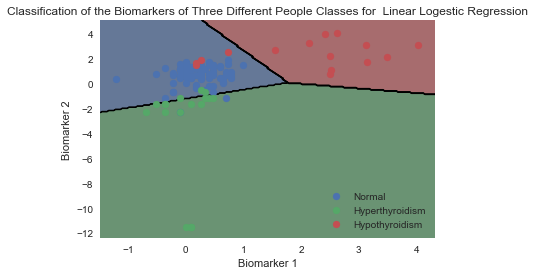

In [19]:
# your code here
logreg1 = LogisticRegressionCV(cv=5,
                               multi_class='ovr').fit(X, Y)


plt_classify(plt.subplot(1,1,1),data_train,logreg1,' Linear Logestic Regression')

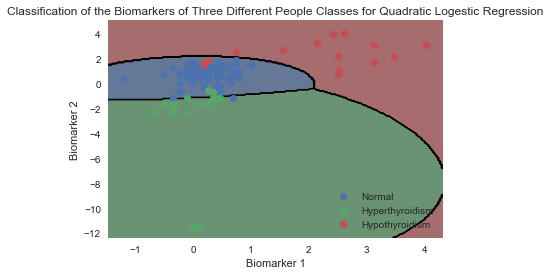

In [20]:
# your code here
logreg2 = polynomial_logreg_estimator.fit(X, Y)

plt_classify(plt.subplot(1,1,1),data_train,logreg2,'Quadratic Logestic Regression')


In [21]:
# your code here


**2.2**

**Your answer here**
How do the different models treat regions where there are few samples? How do they classify such samples?
The decision boundaries make sense, as we can see from the plots, almost all the points are correctly classified in both linear logestic regression and quadratic terms logestic regression. 
After adding quadratic and interaction features, the boundaries' shapes changes from linear to quadratic curves. This is because the quadratic form biomarkers predictors can generate a critcial reigon which is non-linear related with the orignial biomarker values, thus the boundaries of the quadraitc terms logestic regression is not linear.
For the region with few samples, the linear term logestic regression model leaves it whole to one class whose samples are near to that reigon; the quadratic term logestic regression model leaves most of the region to tone class whose samples are near to that reigon, with litte region at the bottom-right to another class 3. Both two methods classified the smaples to class 2.

**2.3**

In [22]:
# your code here
print(np.mean(cross_val_score(logreg1, X, Y, cv=5)))

0.9168831168831169


In [23]:
# your code here
print(np.mean(cross_val_score(logreg2, X, Y, cv=5)))

0.9069264069264069


**Your answer here**
From the accuracy result, the linear logestic regression perfroms better, however, since the accuracy scores of two models are very close, I am not very confidient with this result since there may be some random splits that the quadratic terms logestic regression model has higher accuracy score than linear logestic regression model. After including of the polynomial terms in logistic regression doesn't yield better accuracy. This may because that the variance of the predictors can be enoughly explained by only using the linear terms without interaction of predictors, and after adding quadratic terms, the changes of accuracy is not significant, and it may because the interaction terms included some false interaction effect which affect the accuracy of the model. 

<div class='exercise'><b> Question 3 [20 pts]: Discriminant Analysis</b></div>



**3.1** Consider the following synthetic dataset with two classes. A green star marks a test observation; which class do you think it belongs to? How would LDA classify that observation? How would QDA? Explain your reasoning.

**3.2** Now let's return to the thyroid dataset. Make a table of the total variance of each class for each biomarker.

**3.3** Fit LDA and QDA on the thyroid data, and plot the decision boundaries. Comment on how the decision boundaries differ. How does the difference in decision boundaries relate to characteristics of the data, such as the table you computed above?

**3.1**

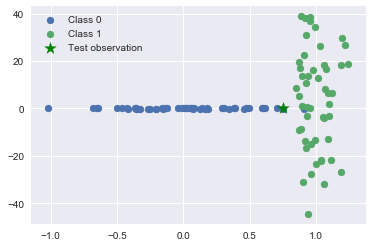

In [24]:
X_blobs, y_blobs = make_blobs(centers=[[0., 0.], [1., 0.]], cluster_std=[[.4, .1], [.1, 20.]], random_state=0)
plt.scatter(X_blobs[y_blobs==0][:,0], X_blobs[y_blobs==0][:,1], label="Class 0")
plt.scatter(X_blobs[y_blobs==1][:,0], X_blobs[y_blobs==1][:,1], label="Class 1")
plt.scatter([.75], [0.], color="green", marker="*", s=150, label="Test observation")
plt.legend();

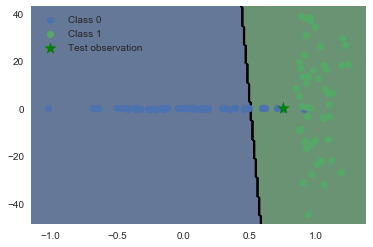

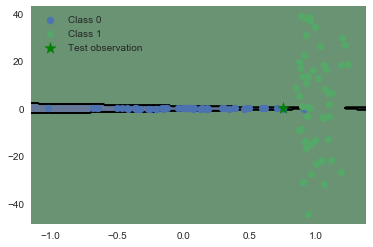

In [25]:
# Your code here
LDA=LinearDiscriminantAnalysis().fit(X_blobs, y_blobs)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(X_blobs[y_blobs==0][:,0], X_blobs[y_blobs==0][:,1], label="Class 0")
ax.scatter(X_blobs[y_blobs==1][:,0], X_blobs[y_blobs==1][:,1], label="Class 1")
ax.scatter([.75], [0.], color="green", marker="*", s=150, label="Test observation")
overlay_decision_boundary(ax, LDA, colors=None, nx=200, ny=200, desaturate=.5)
ax.legend();

QDA=QuadraticDiscriminantAnalysis().fit(X_blobs, y_blobs)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(X_blobs[y_blobs==0][:,0], X_blobs[y_blobs==0][:,1], label="Class 0")
ax.scatter(X_blobs[y_blobs==1][:,0], X_blobs[y_blobs==1][:,1], label="Class 1")
ax.scatter([.75], [0.], color="green", marker="*", s=150, label="Test observation")
overlay_decision_boundary(ax, QDA, colors=None, nx=200, ny=200, desaturate=.5)
ax.legend();

**Your answer here**
The LDA classified the point to the class 1, and the QDA classified the point to the class 0. Since the LDA considered all the samples in one class have same variance around mean, the probability that the point have same variance with class 1 is larger than with class 0 from the scatterplot, thus by LDA the point is more likely to be classified as class 1. The QDA considered all the samples in one class have different variance around mean, and in class 0, the mean variance of y predictor is very small, with that point is within that variance, thus it is more flexiable for the QDA to suggest that that point is in class 0. 

**3.2**

In [26]:
# your code here
def var(data,classes,biomarker):
    a=np.var(data.loc[data_train['Diagnosis']==classes,['Biomarker '+str(biomarker)]])
    return a[0]

vari={'Normal':(var(data_train,1,1),var(data_train,1,2)),
      'Hyperthyroidism':(var(data_train,2,1),var(data_train,2,2)),
       'Hypothyroidism':(var(data_train,3,1),var(data_train,1,2))}
k=pd.DataFrame.from_dict(vari,orient='index',columns=['Biomarker 1', 'Biomarker 2'])
k

,Biomarker 1,Biomarker 2
Normal,0.132315,0.598927
Hyperthyroidism,0.112996,14.809360
Hypothyroidism,1.435367,0.598927


**3.3**

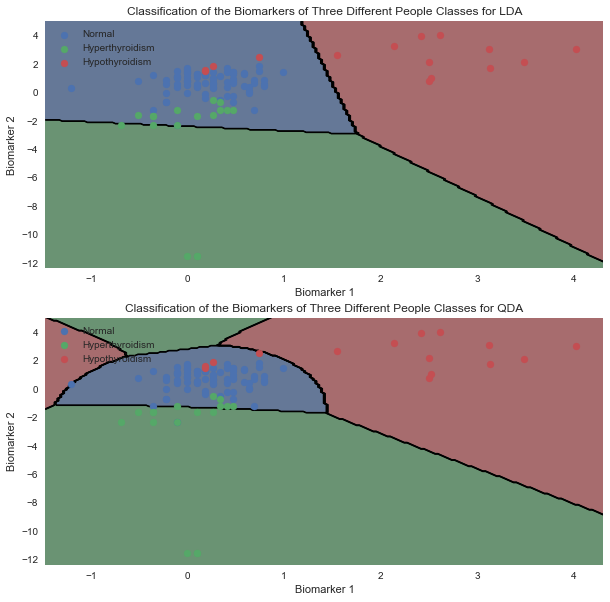

In [27]:
# your code here
plt.figure(figsize=(10,10))
LDA = LinearDiscriminantAnalysis().fit(X, Y)
plt_classify(plt.subplot(2,1,1),data_train,LDA,'LDA')

QDA = QuadraticDiscriminantAnalysis().fit(X, Y)
plt_classify(plt.subplot(2,1,2),data_train,QDA,'QDA')

**Your answer here**
Comment on how the decision boundaries differ. How does the difference in decision boundaries relate to characteristics of the data, such as the table you computed above?
The decision boundaries of the LDA is linear, and the decision boundaries of the QDA are non-linear for some boundries and are linear for other boundries. We can see from the variance table, 

<div class='exercise'> <b> Question 4 [20 pts]: Fit Decision Trees </b> </div> 


We next try out decision trees for thyroid classification. For the following questions, you should use the *Gini* index as the splitting criterion while fitting the decision tree. 

*Hint:* You should use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth.



**4.1**. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the accuracy as a function of the maximum tree depth, on the training set and the mean score on the validation sets for 5-fold CV. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about how this tree will generalize? Which hyperparameter setting gives the best cross-validation performance?

**4.2**: Visualize the decision boundaries of the best decision tree you just fit. How are the shapes of the decision boundaries for this model different from the other methods we have seen so far? Given an explanation for your observation.

**4.3** Explain *in words* how the best fitted model diagnoses 'hypothyroidism' for a new patient. You can use the code below to examine the structure of the best decision tree.

**4.1**

In [28]:
# your code here
scores=np.zeros(9)
accuracy=np.zeros(9)
for i in range(0,9):
    clf=DecisionTreeClassifier(max_depth=i+2,criterion='gini')
    scores[i]= np.mean(cross_val_score(clf,X, Y, cv=5))
    accuracy[i]=clf.fit(X,Y).score(X,Y)

Text(0.5,1,'Change Accuracy Score as the Different Tree-Depth')

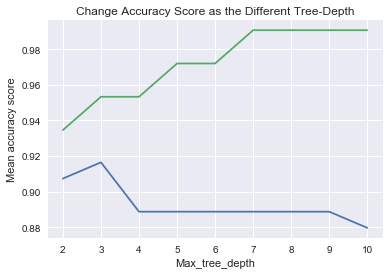

In [29]:
# your code here
plt.plot(np.arange(2,11,1),scores,label='Validation')
plt.plot(np.arange(2,11,1),accuracy,label='Accuracy Score')
plt.xlabel('Max_tree_depth')
plt.ylabel('Mean accuracy score')
plt.title('Change Accuracy Score as the Different Tree-Depth')

**Your answer here**
Yes, when the max-depth of the tree is 3, the the fitted decision tree model achieves near-perfect classification on the training set. We can say that the tree is generalized very well, since there are two predictors and three class, and we only use three layers to make the decision. The hyperparameter of the max_depth is 3. 

**4.2**

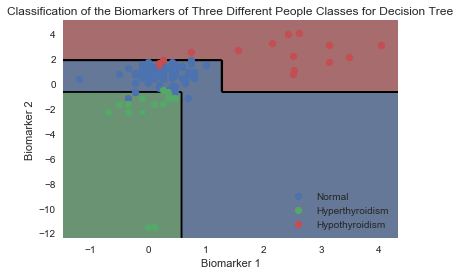

In [30]:
# your code here
clf=DecisionTreeClassifier(max_depth=3,criterion='gini').fit(X,Y)
plt_classify(plt.subplot(1,1,1),data_train,clf,'Decision Tree')

**Your answer here**
As we can see from the plot, the decision boundaries are straight vertical and horizontal lines, which are very different from the other decision boundaries in other models. This is because in the decision trees, we make the decision only by the value of the predictors, whether the value is larger or smaller than a particular value can generate two different leafs. Thus, the decision boundaries are all the straight lines at the level of the critical values for making decisions. 

**4.3**

*Entirely optional note:* You can also generate a visual representation using the `export_graphviz`. However, viewing the generated GraphViz file requires additional steps. One approach is to paste the generated graphviz file in the text box at http://www.webgraphviz.com/. Alternatively, you can run GraphViz on your own computer, but you may need to install some additional software. Refer to the [Decision Tree section of the sklearn user guide](http://scikit-learn.org/stable/modules/tree.html#classification) for more information.

In [31]:
# This code is adapted from
# http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def show_tree_structure(clf):
    tree = clf.tree_

    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print(f"The binary tree structure has {n_nodes} nodes:\n")
    
    for i in range(n_nodes):
        indent = node_depth[i] * "  "
        if is_leaves[i]:
            prediction = clf.classes_[np.argmax(tree.value[i])]
            print(f"{indent}node {i}: predict class {prediction}")
        else:
            print("{}node {}: if X[:, {}] <= {:.3f} then go to node {}, else go to node {}".format(
                indent, i, feature[i], threshold[i], children_left[i], children_right[i]))

In [32]:
# your code here
show_tree_structure(clf)

The binary tree structure has 11 nodes:

node 0: if X[:, 1] <= -0.693 then go to node 1, else go to node 6
  node 1: if X[:, 0] <= 0.582 then go to node 2, else go to node 5
    node 2: if X[:, 0] <= -0.053 then go to node 3, else go to node 4
      node 3: predict class 2
      node 4: predict class 2
    node 5: predict class 1
  node 6: if X[:, 0] <= 1.270 then go to node 7, else go to node 10
    node 7: if X[:, 1] <= 1.879 then go to node 8, else go to node 9
      node 8: predict class 1
      node 9: predict class 3
    node 10: predict class 3


In [33]:
# your code here
export_graphviz(clf, out_file='tree_viz.dot')

**Your answer here**
If the patient's biomarker 2 is larger than -0.693 when the biomaker 1 is larger than 1.270, or his biomarker 2 is larger than 1.879 when the biomarker 1 is less than 1.270, he will be classified as hypothyroidism.

<div class='exercise'><b> Question 5 [18 pts]: k-NN and Model comparison </b> </div>

We have now seen six different ways of fitting a classification model: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **decision trees**, and in this problem we'll add **k-NN**. Which of these methods should we use in practice for this problem? To answer this question, we now compare and contrast these methods.



**5.1** Fit a k-NN classifier with uniform weighting to the training set. Use 5-fold CV to pick the best $k$.

*Hint: Use `KNeighborsClassifier` and `cross_val_score`.*

**5.2** Plot the decision boundaries for each of the following models that you fit above. For models with hyperparameters, use the values you chose using cross-validation.
- Logistic Regression (linear)
- Logistic Regression (polynomial)
- Linear Discriminant Analysis 
- Quadratic Discriminant Analysis
- Decision Tree
- k-NN

Comment on the difference in the decision boundaries between the following pairs of models. Why does this difference make sense given how the model works?
- Linear logistic regression; LDA
- Quadratic logistic regression; QDA.
- k-NN and whichever other model has the most complex decision boundaries

**5.3** Describe how each model classifies an observation from the test set in one short sentence for each (assume that the model is already fit). For example, for the linear regression classifier you critiqued in hw5, you might write: "It classifies the observation as class 1 if the dot product of the feature vector with the the model coefficients (with constant added) exceeds 0.5."

- Logistic Regression (One-vs-Rest)
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- k-Nearest-Neighbors Classifier
- Decision Tree

**5.4** Estimate the validation accuracy for each of the models. Summarize your results in a graph or table. (Note: for some models you have already run these computations; it's ok to redo them here if it makes your code cleaner.)

**5.5** Based on everything you've found in this question so far, which model would you expect to perform best on our test data? 

Now evaluate each fitted model's performance on the test set. Also, plot the same decision boundaries as above, but now showing the test set. How did the overall performance compare with your performance estimates above? Which model actually performed best? Why do you think this is the case?

**5.6**. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Interpretability

If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? Justify your choice in terms of at least 3 different aspects.

**5.1**

In [34]:
# your code here

scores=np.zeros(80)

for i in range(0,80):
    KNN=KNeighborsClassifier(n_neighbors=i+1).fit(X,Y)
    scores[i]= np.mean(cross_val_score(KNN,X, Y, cv=5))
    
scores[np.argmax(scores)]
print ('The best K is ' + str(np.argmax(scores)+1))

The best K is 4


**5.2**

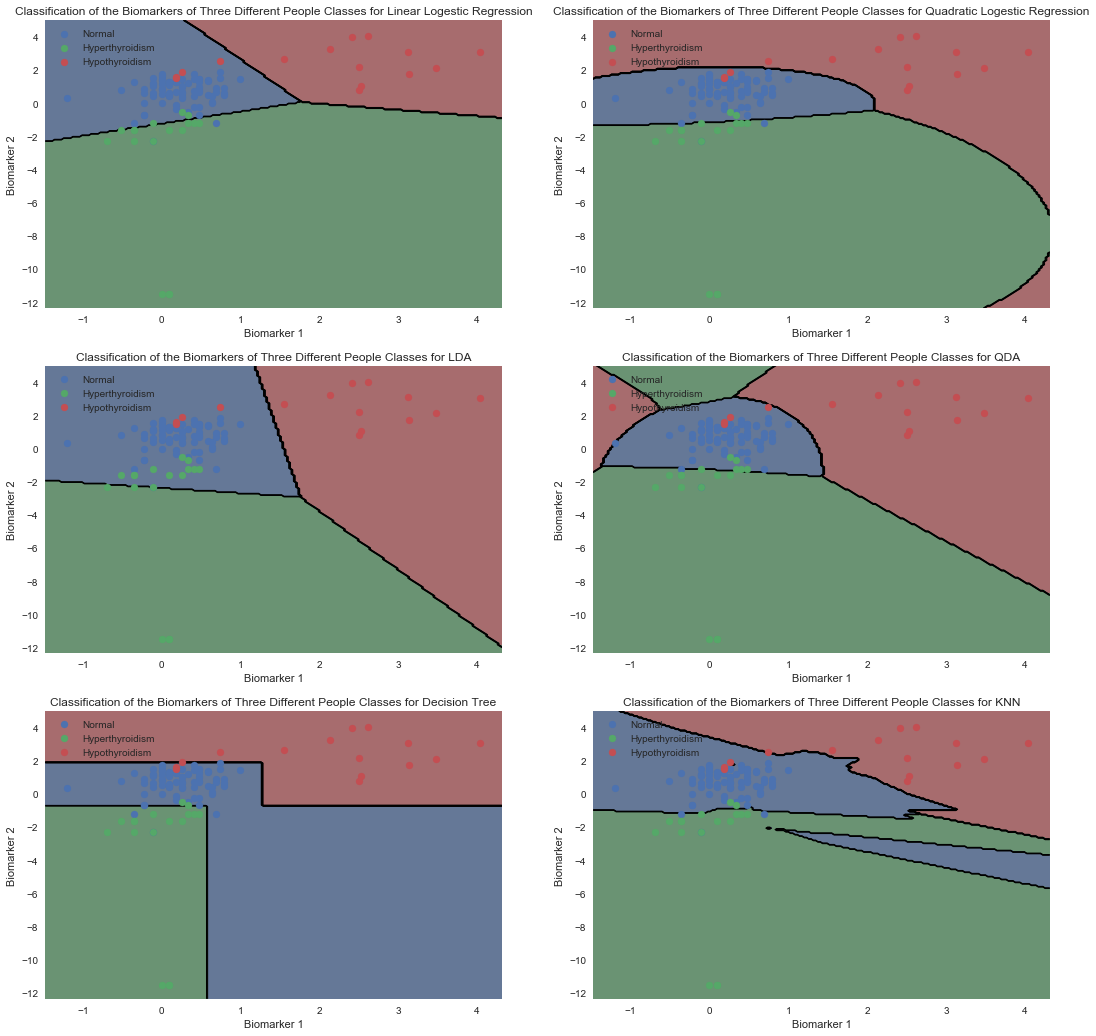

In [35]:
# Your code here
KNN=KNeighborsClassifier(n_neighbors=4).fit(X,Y)
plt.figure(figsize=(18,18))

plt_classify(plt.subplot(3,2,1),data_train,logreg1,'Linear Logestic Regression')
plt_classify(plt.subplot(3,2,2),data_train,logreg2,'Quadratic Logestic Regression')
plt_classify(plt.subplot(3,2,3),data_train,LDA,'LDA')
plt_classify(plt.subplot(3,2,4),data_train,QDA,'QDA')
plt_classify(plt.subplot(3,2,5),data_train,clf,'Decision Tree')
plt_classify(plt.subplot(3,2,6),data_train,KNN,'KNN')


**your answer here**
#Linear logistic regression; LDA
The linear logistic is better than LDA. the Linear regression include more points than LDA. The linear logisitcs is relatively robust, flexible and easily used, and it lends itself to a meaningful interpretation. LDA assumes the explanatory variables to be normally distributed with equal covariance matrices. In Linear Logistics, unlike in the case of LDA, no assumptions are made regarding the distribution of the explanatory variables.

#Quadratic logistic regression; QDA.
Quadratic Logistic doea not have straight line in the boundary but QDA has straight line in the boundary curve. The reason of different boundary is due to the data. We find out that may not normally distribution and equal variance.

#k-NN and QDA
KNN's decision boundary does not seem linear nor quadratic. QDA serves as a compromise between the non-parametric KNN method and the linear LDA and logistic regression approaches.Since QDA assumes a quadratic decision boundary, it can accurately model a wider range of problems than can the linear methods. Though not as flexible as KNN, QDA can perform better in the presence of a limited number of training observations because it does make some assumptions about the form of the decision boundary

**5.3**

**Your answer here**
#Logistic Regression (One-vs-Rest)

It classifies the observation as class 1 if the inverse logit of dot product of the feature vector with the the first model coefficients (with constant added) exceeds 0.5, and with the second and third model coefficients (with constant added) below 0.5.
It classifies the observation as class 2 if the inverse logit of dot product of the feature vector with the the second model coefficients (with constant added) exceeds 0.5, and with the first and third model coefficients (with constant added) below 0.5.
It classifies the observation as class 3 if the inverse logit of dot product of the feature vector with the the third model coefficients (with constant added) exceeds 0.5, and with the first and second model coefficients (with constant added) below 0.5.

#Linear Discriminant Analysis

It classifies the observation as class 1 if the predictor vector is more close to the mean of class 1 with minimum variance in class 1; It classifies the observation as class 2 if the predictor vector is more close to the mean of class 2 with minimum variance in class 2;It classifies the observation as class 3 if the predictor vector is more close to the mean of class 3 with minimum variance in class 3.

#Quadratic Discriminant Analysis

It classifies the observation as class 1 if the predictor vector maximize the class 1 discriminate function, which means the predictor vector is more close to the mean of class 1 with minimum variance-covariance-variance value in class 1; It classifies the observation as class 2 if the predictor vector is more close to the mean of class 2 with minimum variance-covariance-variance value in class 2; It classifies the observation as class 3 if the predictor vector is more close to the mean of class 3 with minimum variance-covariance-variance value in class 3.

#k-Nearest-Neighbors Classifier

If the least 4 distance samples from the patient sample of biomaker 1 and biomarker 2 are class 1, then the patient sample is class 1; if they are class 2, then the patient sample is class 2; if they are class 3, then the patient sample is class 3.

#Decision Tree

If the patient's biomarker 2 is larger than -0.693 when the biomaker 1 is larger than 1.270, or his biomarker 2 is larger than 1.879 when the biomarker 1 is less than 1.270, he will be classified as class 3.
If the patient's biomarker 2 is less than -0.693 when the biomaker 1 is less than 0.582, he will be classified as class 2.
If the patient's biomarker 2 is larger than -0.693 and less than 1.879, or biomarker 1 is larger than 0.582, he will be classified as class 1.

**5.4**

In [36]:
# your code here
valid_accuracy={'Linear':[logreg1.score(X,Y)],'Quad':[logreg2.score(X,Y)],
                'LDA':[LDA.score(X,Y)],'QDA':[QDA.score(X,Y)],
                'DecisionTree':[clf.score(X,Y)],'KNN':[KNN.score(X,Y)]}
accuracy_df=pd.DataFrame.from_dict(data=valid_accuracy,orient='index',columns=['Validation Accuracy'])

In [37]:
# your code here
accuracy_df

,Validation Accuracy
Linear,0.915888
Quad,0.934579
LDA,0.850467
QDA,0.878505
DecisionTree,0.953271
KNN,0.925234


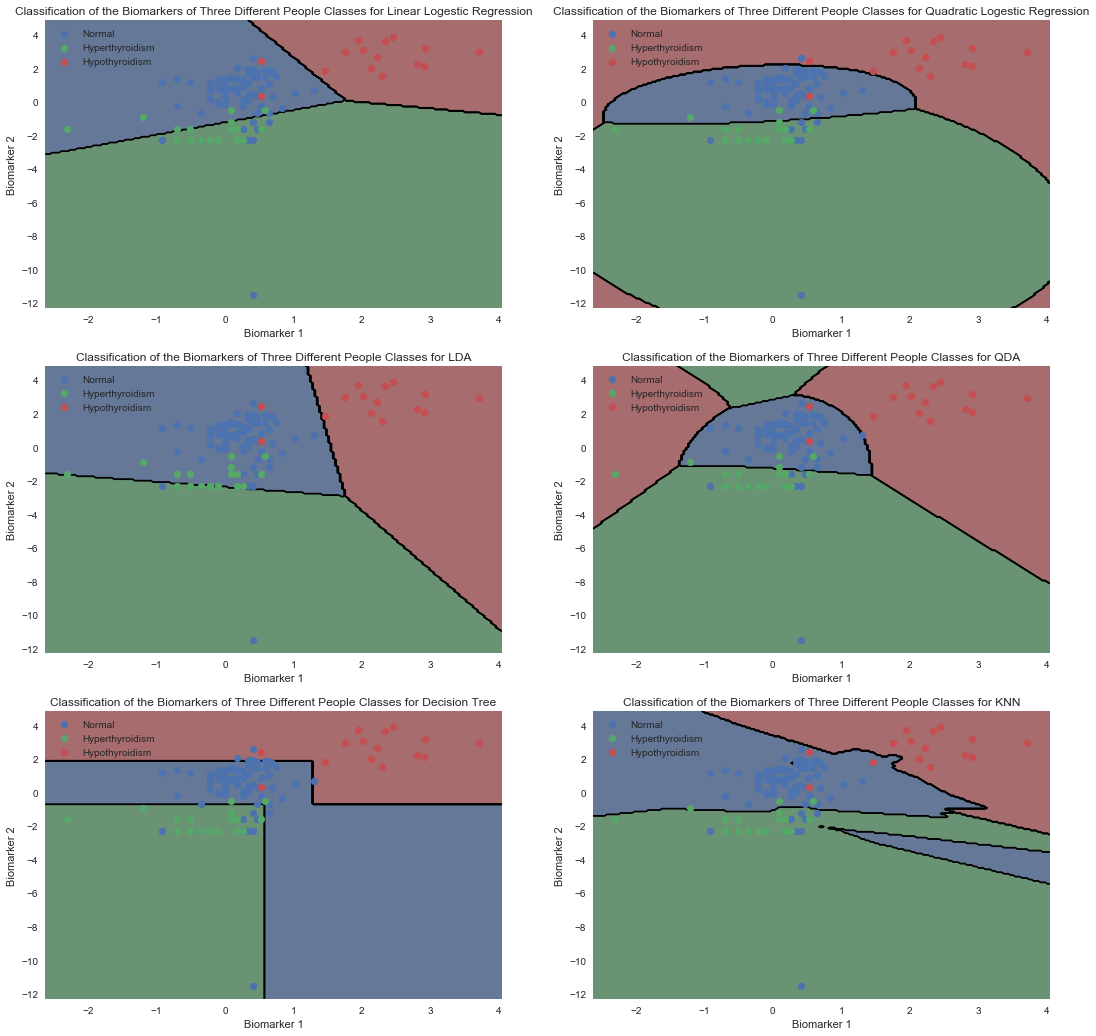

In [38]:
# your code here
plt.figure(figsize=(18,18))

plt_classify(plt.subplot(3,2,1),data_test,logreg1,'Linear Logestic Regression')
plt_classify(plt.subplot(3,2,2),data_test,logreg2,'Quadratic Logestic Regression')
plt_classify(plt.subplot(3,2,3),data_test,LDA,'LDA')
plt_classify(plt.subplot(3,2,4),data_test,QDA,'QDA')
plt_classify(plt.subplot(3,2,5),data_test,clf,'Decision Tree')
plt_classify(plt.subplot(3,2,6),data_test,KNN,'KNN')


**Your answer here**


**5.5**

In [39]:
# your code here
X_test=data_test.loc[:,['Biomarker 1','Biomarker 2']].values
Y_test=data_test.loc[:,['Diagnosis']].values

In [40]:
# your code here
Test_accuracy={'Linear':[logreg1.score(X_test,Y_test)],'Quad':[logreg2.score(X_test,Y_test)],
                'LDA':[LDA.score(X_test,Y_test)],'QDA':[QDA.score(X_test,Y_test)],
                'DecisionTree':[clf.score(X_test,Y_test)],'KNN':[KNN.score(X_test,Y_test)]}
accuracy_df=pd.DataFrame.from_dict(data=Test_accuracy,orient='index',columns=['Test Accuracy'])
accuracy_df

,Test Accuracy
Linear,0.842593
Quad,0.861111
LDA,0.814815
QDA,0.851852
DecisionTree,0.833333
KNN,0.851852


**your answer here**
Based on everything you've found in this question so far, which model would you expect to perform best on our test data?

From the accuracy table, we find out that the Quadratic Logistic is the best

How did the overall performance compare with your performance estimates above? 

Quad_log>QDA=knn>linear_log>Decision Tree>LDA. the overall performance is good in Quad_log 

Which model actually performed best? 

the Quad_logistic is best.

Why do you think this is the case?

Because three classes are not overlaid very much,and the boundaries of these three classes are generally clear, with the sample distributed separately inside one class. Thus the logestic regression can give a better prediction accuracy than the other prediction methods. Since the quadratic logestic regression are more general than the linear logestic regression and it can give a more flexiable decision boundaries, thus it can give better prediction than the linear logestic regression.

**5.6**

**your answer here**


<div class='exercise'><b> Question 6: [2 pts] Including an 'abstain' option </b></div>
**Note this question is only worth 2 pts. **

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost.  How could one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.



**6.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 2? Note that this needs to be evaluated on the patients in the test set. 

**6.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.



**6.1**

**Your answer here**


In [41]:
# your code here


In [42]:
# your code here


**6.2**

**Your answer here**
